# Final Capstone - Generative Adversarial Network (GAN)

The problem I am attempting to solve is the privacy concern a user might have when wanting to upload an image of himself or herself to the Internet, but the image includes other individuals.

I am proposing to use artificial human faces to replace real human faces in a user's picture before uploading it to the Internet. A few of the potential benefits:
- Removes / limits privacy concern a user might have about using images of himself or herself with other individuals.
- In addition to manual image manipulation, it provides an automated option for manipulating images.
- After the image has undergone a transformation, the user could use the image for a profile picture on social networking platforms or the image could be used on a platform where users are looking to meet new people. If the user selected all faces in the image to be replaced, it could be used as a family avatar or an avatar for a special group of friends or as a profile picture for a platform where the user wants to remain anonymous.

My dataset will contain images of human faces. I plan to use a web scraper to retrieve images of human faces. The scraper consists of the following phases:
- Scrape a website of the 100 most popular names for men and women in the United States.
- Use each name to conduct an image search using the Bing search engine and scrape the search results in order to retrieve the image URL.
- Use each image URL to scrape a website and save the image to disk.

After compiling my dataset, the images associated with each name will receive a label of either zero or one. For example, if the name 'James' was used to conduct an image search, then all the images associated with that search will receive a label of 0. Additionally, if the name ‘Jennifer’ was used to conduct an image search, then all the images associated with that search will receive a label of 1.

I then plan to use these labeled images to train a Convolutional Neural Network to identify / classify gender in images and depending on the outcome of this CNN either a GAN that generates female faces will be used or a GAN that generates male faces will be used.

In [1]:
# Install selenium and chromedriver for web scraping
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

     |████████████████████████████████| 911kB 3.5MB/s 
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic In

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
import json
import requests
import os
import sys
import time
import random
import warnings
import itertools
from google.colab import drive
from google.colab.patches import cv2_imshow
from bs4 import BeautifulSoup
from selenium import webdriver
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from keras.optimizers import Adam
from keras import backend as K
from IPython import display

# Display preference
%matplotlib inline
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Web Scraper

```scroll``` function is used to scroll down an infinite / continuous scrolling web page.

In [0]:
# Function to scroll down web page
def scroll(driver, timeout):
    
    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")

    while True:
    
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait
        time.sleep(timeout)

        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        
        # If heights are equal terminate looping
        if new_height == last_height:
            
            break
        
        last_height = new_height   

```all_links``` is used to scroll down web pages and scrape the content on the web page and returns either a list of image links or a BeautifulSoup object. If action parameter has a value equal to 1, then code built for Bing image search results is executed and returns a list of image links. If action parameter has a value equal to 0, then a BeautifulSoup object is returned.

In [0]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

def all_links(url, action, gender=0):
    
    # Setup driver
    driver = webdriver.Chrome('chromedriver', chrome_options=chrome_options)

    # Wait before throwing an exception
    driver.implicitly_wait(20)

    # Open the page
    driver.get(url)
    
    # Start scrolling
    scroll(driver, 10)
    
    # Beautiful Soup parses page_source
    soup = BeautifulSoup(driver.page_source, 'lxml')
    
    # Close the driver
    driver.close()

    if action == 1:
    
        # Empty dictionary to store m from page source
        get_m = {}
    
        # Counter for get_m dictionary
        get_m_counter = 0

        # Looping through all the a elements in the page source
        for link in soup.find_all('a', {'class': 'iusc'}):
    
            # Add values to dictionary
            get_m[get_m_counter] = link.get('m')
        
            # Increment counter
            get_m_counter += 1
        
        # Convert from string to dictionary
        for key, value in get_m.items():
            get_m[key] = json.loads(value)
        
        # Empty list to store image links
        links = []
    
        # Loop through get_m dictionary and add image links to links list
        for value in get_m.values():
            links.append([value['murl'], gender])
        
        return links
    else:
        return soup

In [0]:
# List of names to search
names = []

Scrape ```name_url``` to retrieve the 200 most popular names in the United States and store in ```names``` list (100 male names and 100 female names).

In [0]:
# Popular names url
name_url = 'https://www.ssa.gov/oact/babynames/decades/century.html'

# Retrieve Beautiful Soup object
soup_name = all_links(name_url, 0)

# Get td tag
td_tag = soup_name.select('.t-stripe > tbody > tr > td')

# Add name to search names
names += [name.get_text().lower() for name in td_tag if name.get_text().isalpha()]

Separate values from ```names``` list into ```male_names``` list and ```female_names``` list. Male names given the label 0 and Female names given the label 1.

In [0]:
# List for male names
male_names = []

# List for female names
female_names = []

for index, name in enumerate(names, 0):
    if index % 2 == 0:
        male_names.append([name, 0])
    else:
        female_names.append([name, 1])

```get_links``` is used to conduct an image search using the Bing search engine and scrape the search results in order to retrieve the image URL. It relies on ```all_links``` and ```scroll``` functions.

In [0]:
# Get image links for each name
def get_links(names):
    
    image_links_name = []
    pre_image_links_count = 0
    post_image_links_count = 0
    
    for index in range(len(names)):
        
        # Update url
        url = 'https://www.bing.com/images/search?q=' + names[index][0] + '&qs=n&form=QBIR&qft=%20filterui%3Alicense-L2_L3_L4_L5_L6_L7%20filterui%3Aface-face&sp=-1&pq=' + names[index][0] + '&sc=8-9&sk=&cvid=8C2D8EC9A35A4948980A61669549C180'    
    
        # Number of image links before
        pre_image_links_count = len(image_links_name)
    
        # Add image links
        image_links_name += all_links(url, 1, names[index][1])
        
        # Number of image links after
        post_image_links_count = len(image_links_name)
        
        # Number of image links associated with name
        print('{} resulted in {} image links'.format(names[index][0], (post_image_links_count - pre_image_links_count)))
        
    return image_links_name

Conduct Bing image search for each value in ```male_names``` and ```female_names``` and store image link(s) in ```image_links```.

In [0]:
# List for image links
image_links = []

In [0]:
# Add male name image links
image_links += get_links(male_names) 

james resulted in 175 image links
john resulted in 175 image links
robert resulted in 175 image links
michael resulted in 175 image links
william resulted in 175 image links
david resulted in 175 image links
richard resulted in 175 image links
joseph resulted in 175 image links
thomas resulted in 175 image links
charles resulted in 175 image links
christopher resulted in 175 image links
daniel resulted in 175 image links
matthew resulted in 175 image links
anthony resulted in 175 image links
donald resulted in 175 image links
mark resulted in 175 image links
paul resulted in 175 image links
steven resulted in 175 image links
andrew resulted in 175 image links
kenneth resulted in 175 image links
joshua resulted in 175 image links
george resulted in 175 image links
kevin resulted in 175 image links
brian resulted in 175 image links
edward resulted in 175 image links
ronald resulted in 175 image links
timothy resulted in 175 image links
jason resulted in 175 image links
jeffrey resulted i

In [0]:
# Add female name image links
image_links += get_links(female_names)

mary resulted in 175 image links
patricia resulted in 175 image links
jennifer resulted in 175 image links
linda resulted in 175 image links
elizabeth resulted in 175 image links
barbara resulted in 175 image links
susan resulted in 175 image links
jessica resulted in 175 image links
sarah resulted in 175 image links
karen resulted in 175 image links
nancy resulted in 175 image links
margaret resulted in 175 image links
lisa resulted in 175 image links
betty resulted in 175 image links
dorothy resulted in 175 image links
sandra resulted in 532 image links
ashley resulted in 175 image links
kimberly resulted in 175 image links
donna resulted in 175 image links
emily resulted in 175 image links
michelle resulted in 175 image links
carol resulted in 175 image links
amanda resulted in 175 image links
melissa resulted in 175 image links
deborah resulted in 175 image links
stephanie resulted in 175 image links
rebecca resulted in 175 image links
laura resulted in 175 image links
sharon resul

In [0]:
print('There are {} image links'.format(len(image_links)))

There are 35560 image links


Cycle through the 35,560 links stored in ```image_links``` and submit a request using ```requests.get()```. If the request/response is valid, scrape image and save it to disk. If request/response is not valid, then skip over it and move onto the next image link.

In [0]:
# Header to accompany get request
headers = {'user-agent': 'scraper - school project (bengriffith@outlook.com)'}

# Counter to be used in image file name
image_counter = 0

# Counter for images scraped
scraped_counter = 0

# Counter for exceptions occurred
exception_counter = 0

# Write images to disk
for image_link in image_links:
    with open('../gdrive/My Drive/colab/gan/images/face_' + str(image_counter) + '_' + str(image_link[1]) + '.png', 'wb') as f:
        try:
            response = requests.get(image_link[0], headers=headers, timeout=45)
            
            if response.ok:
                f.write(response.content)
                scraped_counter += 1
        except:
            exception_counter += 1
            continue
    image_counter += 1

In [0]:
print('There were {} images scraped'.format(scraped_counter))
print('There were {} images not scraped'.format((len(image_links) - scraped_counter)))

There were 35241 images scraped
There were 319 images not scraped


In [0]:
# Define image directory paths
images_directory = '../gdrive/My Drive/colab/gan/images/'
images_cropped_directory = '../gdrive/My Drive/colab/gan/images_cropped_stage/'
images_cropped_separated = '../gdrive/My Drive/colab/gan/images_cropped_'

Pass through scraped images stored in ```images_directory``` and load image using ```image = cv2.imread()``` / start manipulation with ```image.shape[]```. If this results in ```AttributeError```, remove image from ```images_directory```.

In [0]:
# Remove images that create AttributeError
files_removed = 0

for filename in sorted(os.listdir(images_directory)):
    
    try:
        image = cv2.imread(images_directory + filename)
        (h, w) = image.shape[:2]
    except AttributeError:
        files_removed += 1
        os.remove(images_directory + filename)
        
print('There were {} files removed due to AttributeError'.format(files_removed))

There were 360 files removed due to AttributeError


## Face Detection and Gender Convolutional Neural Network (CNN)

OpenCV includes a deep learning-based face detector and in order to implement OpenCV's deep neural network module with Caffee models, we'll need two sets of files. The path to these files are stored in ```prototxt``` and ```model```.

In [0]:
prototxt = '../gdrive/My Drive/colab/gan/supporting/deploy.prototxt'
model = '../gdrive/My Drive/colab/gan/supporting/res10_300x300_ssd_iter_140000.caffemodel'

After loading the model using ```prototxt``` and ```model```, the following takes place:
- Load the image and retrieve dimensions
- Create a blob to take care of pre-processing
- Detect face by passing the blob into the model
- If the confidence threshold is met, then retrieve coordinates for face and save face image

In [0]:
file_counter = 0

for filename in sorted(os.listdir(images_directory)):

    # Image path
    image_path = images_directory + filename
    
    # Load model
    net = cv2.dnn.readNetFromCaffe(prototxt, model)

    # Load image
    image = cv2.imread(image_path)
    (h, w) = image.shape[:2]
    
    # Blob for the image
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    # Pass blob through network and retrieve detections / predictions
    net.setInput(blob)
    detections = net.forward()
    
    for i in range(detections.shape[2]):
        
        # Get confidence associated with the prediction
        confidence = detections[0, 0, i, 2]
    
        if confidence > 0.95:
            
            # Coordinates for the bounding box
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype('int')
        
            # Coordinates for face
            face = image[startY:endY, startX:endX]
        
            # Save face image 
            cv2.imwrite(images_cropped_directory + filename, face)

            file_counter += 1
        
print('There were {} face images added to images_cropped_stage directory'.format(file_counter))

There were 35054 face images added to images_cropped_stage directory


In [0]:
# List for image data
image_data = []

# List to store detected face
data = []

# List to store labels
labels = []

After saving images to ```images_directory```, I created sub-directories and moved a portion of all images from ```images_directory``` into each in order to avoid encountering a Colab timeout error.

Next, go through all images in each sub-directory and load / resize the image using ```cv2.imread()``` and ```cv2.resize()```. Then store the image and label into ```image_data```. Again, males are given label 0 and females are given label 1.

In [6]:
for folder in range(1, 6):

    # Counter
    images_processed = 0

    # Populate image_data list
    for filename in sorted(os.listdir(images_cropped_separated + str(folder) + '/')):
        image_path = images_cropped_separated + str(folder) + '/' + filename
        image = cv2.imread(image_path)[:,:,::-1] # Convert to RGB
        image = cv2.resize(image, (64, 64))
        image_data.append([image, int(filename[filename.find('.') - 1])]) 
        images_processed += 1

    print('{} images processed from Folder {}'.format(images_processed, folder))

6942 images processed from Folder 1
7360 images processed from Folder 2
6087 images processed from Folder 3
6226 images processed from Folder 4
8239 images processed from Folder 5


In [0]:
# Separate image data into data list and labels list
for image in image_data:
    data.append(image[0])
    labels.append(image[1])

print('There are {} elements in data'.format(len(data)))
print('There are {} elements in labels'.format(len(labels)))

There are 34853 elements in data
There are 34853 elements in labels


In [0]:
# Convert data and labels lists to numpy arrays
data = np.array(data, dtype='float') / 255.0 # Normalize images from 0 to 1
labels = np.array(labels)

In [0]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20)

In [0]:
print('There are {} records in the train dataset'.format(X_train.shape[0]))
print('There are {} records in the test dataset'.format(X_test.shape[0]))

There are 27882 records in the train dataset
There are 6971 records in the test dataset


```model``` function is used to create a CNN to be used for gender classification.

In [0]:
def model(height, width, depth, num_classes):
    model = tf.keras.Sequential()
    input_shape = (height, width, depth)
    channel_dimension = -1
    
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='sigmoid'))
    
    return model

For CNN, define ```epochs```, ```batch_size``` and ```image_dimensions```.

In [0]:
epochs = 15
batch_size = 32
image_dimensions = (64, 64, 3)

Initialize, compile and train ```gender_model```.

In [0]:
gender_model = model(image_dimensions[0], image_dimensions[1], image_dimensions[2], 1)

In [0]:
gender_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [0]:
gender = gender_model.fit(X_train, y_train, batch_size=batch_size, 
                          validation_data=(X_test, y_test), 
                          epochs=epochs, 
                          verbose=1)

Epoch 1/15
872/872 [==============================] - 267s 306ms/step - loss: 0.4314 - accuracy: 0.8145 - val_loss: 0.3244 - val_accuracy: 0.8748
Epoch 2/15
872/872 [==============================] - 268s 308ms/step - loss: 0.3137 - accuracy: 0.8800 - val_loss: 0.2925 - val_accuracy: 0.8913
Epoch 3/15
872/872 [==============================] - 268s 308ms/step - loss: 0.2715 - accuracy: 0.9004 - val_loss: 0.2757 - val_accuracy: 0.9029
Epoch 4/15
872/872 [==============================] - 263s 302ms/step - loss: 0.2414 - accuracy: 0.9151 - val_loss: 0.2480 - val_accuracy: 0.9126
Epoch 5/15
872/872 [==============================] - 270s 309ms/step - loss: 0.2097 - accuracy: 0.9276 - val_loss: 0.2482 - val_accuracy: 0.9148
Epoch 6/15
872/872 [==============================] - 265s 304ms/step - loss: 0.1830 - accuracy: 0.9376 - val_loss: 0.2441 - val_accuracy: 0.9208
Epoch 7/15
872/872 [==============================] - 266s 305ms/step - loss: 0.1572 - accuracy: 0.9459 - val_loss: 0.2527 -

In [0]:
score = gender_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.36164069175720215
Test accuracy: 0.9272701144218445


In [0]:
# Save gender_model to disk for future use
gender_model.save('../gdrive/My Drive/colab/gan/supporting/gender_model.h5')

### Gender CNN Evaluation:


In [0]:
# CNN predictions
predictions = gender_model.predict_classes(X_test, batch_size=32)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


#### Classification Report

In [0]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3479
           1       0.94      0.92      0.93      3492

    accuracy                           0.93      6971
   macro avg       0.93      0.93      0.93      6971
weighted avg       0.93      0.93      0.93      6971



#### Confusion Matrix

In order to generate a nice visualization for the confusion matrix, I am using the following function taken from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix.

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

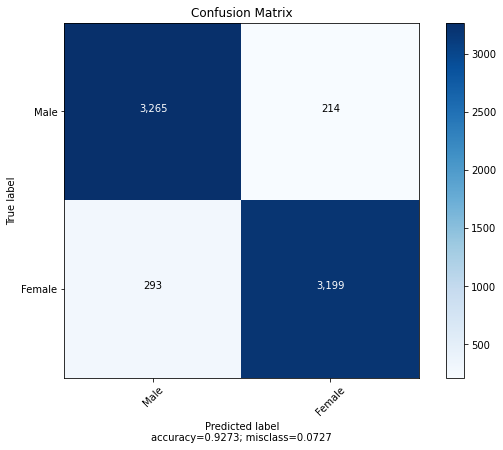

In [0]:
confusion = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm=confusion, target_names = ['Male', 'Female'], title = 'Confusion Matrix', normalize=False)

#### Receiver Operating Characteristic Curve (ROC) and Area Under the Curve (AUC)

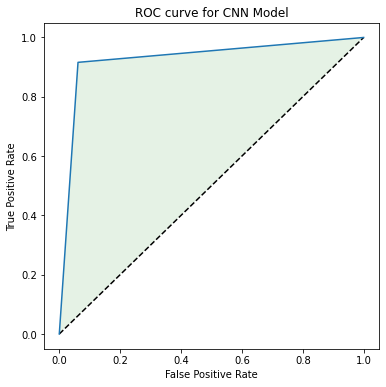

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.fill(fpr, tpr, 'green', alpha=0.1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for CNN Model')
plt.show()

In [0]:
auc = roc_auc_score(y_test, predictions)
print('Area under the ROC curve: {:.3f}'.format(auc))

Area under the ROC curve: 0.927


#### Training / Validation Loss and Accuracy

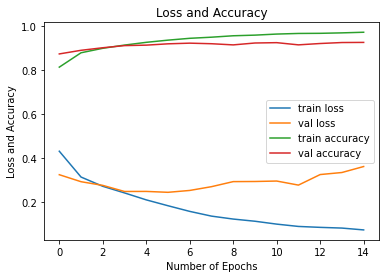

In [0]:
# Plot loss and accuracy
epoch_range = np.arange(0, epochs)
plt.figure()
plt.plot(epoch_range, gender.history['loss'], label='train loss')
plt.plot(epoch_range, gender.history['val_loss'], label='val loss')
plt.plot(epoch_range, gender.history['accuracy'], label='train accuracy')
plt.plot(epoch_range, gender.history['val_accuracy'], label='val accuracy')
plt.title('Loss and Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss and Accuracy')
plt.legend()
plt.show()

As the number of epochs increases, the following occurs:
- Training loss gradually decreases and appears to start leveling off at epoch 14
- Training accuracy gradually increases and appears to start leveling around epoch 13 and 14
- Validation loss (while it increases and decreases) gradually increases 
- Validation accuracy (while it increases and decreases) gradually increases and appears to start leveling off around epoch 12

## Generative Adversarial Network

In order to replace real human faces with artificial faces in user images, a GAN will be implemented. Throughout the implementation below, I referenced the Deep Convolutional GAN tutorial from TensorFlow's website (https://www.tensorflow.org/tutorials/generative/dcgan).

In [7]:
# Female images
image_females = []

# Male images
image_males = []

# Separate into female and male
for image in image_data:
    if image[1] == 1:
        image_females.append(image[0])
    else:
        image_males.append(image[0])

print('There are {} female images'.format(len(image_females)))
print('There are {} male images'.format(len(image_males)))

There are 17388 female images
There are 17466 male images


In [0]:
# Convert image_females and image_males lists to numpy arrays
image_females = np.array(image_females, dtype='float32')
image_males = np.array(image_males, dtype='float32')

In [0]:
# Normalize images to [-1, 1]
image_females = (image_females - 127.5) / 127.5
image_males = (image_males - 127.5) / 127.5

In [0]:
female_buffer_size = len(image_females)
male_buffer_size = len(image_males)
batch_size = 128

In [0]:
# Batch and shuffle the training dataset
train_female_dataset = tf.data.Dataset.from_tensor_slices(image_females).shuffle(female_buffer_size).batch(batch_size)
train_male_dataset = tf.data.Dataset.from_tensor_slices(image_males).shuffle(male_buffer_size).batch(batch_size)

```create_generator``` creates the generator model that learns to produce images that look real. The generator utilizes ```layers.Conv2DTranspose()``` layers to produce an image from random noise.

In [0]:
def create_generator():
    generator = tf.keras.Sequential()
    init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)
    generator.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU())

    generator.add(layers.Reshape((8, 8, 256)))
    assert generator.output_shape == (None, 8, 8, 256)

    generator.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', kernel_initializer=init, use_bias=False))
    assert generator.output_shape == (None, 8, 8, 256)
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU())

    generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False))
    assert generator.output_shape == (None, 16, 16, 128)
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU())

    generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', kernel_initializer=init, use_bias=False))
    assert generator.output_shape == (None, 16, 16, 64)
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU())

    generator.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False))
    assert generator.output_shape == (None, 32, 32, 32)
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU())

    generator.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False, activation='tanh'))
    assert generator.output_shape == (None, 64, 64, 3)

    return generator

```create_discriminator``` creates the discriminator model that learns to tell real images apart from fakes. The discriminator is a CNN-based image classifier.

In [0]:
def create_discriminator():
    discriminator = tf.keras.Sequential()
    discriminator.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.25))

    discriminator.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.25))

    discriminator.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.3))

    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(1))

    return discriminator

In [0]:
# Initialize generator and discriminator
male_generator = create_generator()
male_discriminator = create_discriminator()

female_generator = create_generator()
female_discriminator = create_discriminator()

The generator loss quantifies how well it was able to trick the discriminator. While the discriminator loss quantifies how well it is able to distinguish real images from fakes.

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [0]:
# Training
epochs = 150
noise_dim = 100
number_examples_to_generate = 8

seed = tf.random.normal([number_examples_to_generate, noise_dim])

In ```train_step```, the following sequence occurs:
1. The training loop begins with generator receiving a random seed as input, which is used to produce an image.
2. The discriminator is used to classify real images and fake images. 
3. The loss is calculated for the generator and discriminator.
4. The gradients are used to update the generator and discriminator.

In [0]:
@tf.function
def train_step(images, generator_model, discriminator_model):

    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        
        generated_images = generator_model(noise, training=True)

        real_output = discriminator_model(images, training=True)
        fake_output = discriminator_model(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = generator_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = discriminator_tape.gradient(disc_loss, discriminator_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

In [0]:
def train(dataset, epochs, generator_model, discriminator_model):

    for epoch in range(epochs):

        start = time.time()

        for image_batch in dataset:
            train_step(image_batch, generator_model, discriminator_model)

        display.clear_output(wait=True)
        generate_and_save_images(generator_model, epoch + 1, seed)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    display.clear_output(wait=True)
    generate_and_save_images(generator_model, epochs, seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):

    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

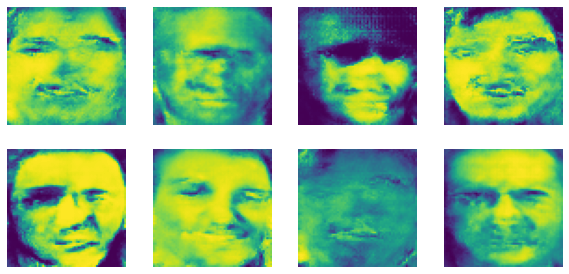

In [23]:
# Train on male images
train(train_male_dataset, epochs, male_generator, male_discriminator)

In [0]:
# Save male_generator to disk for future use
male_generator.save('../gdrive/My Drive/colab/gan/supporting/male_generator_model.h5')

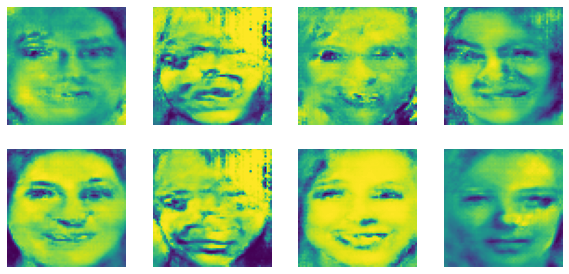

In [38]:
# Train on female images
train(train_female_dataset, epochs, female_generator, female_discriminator)

In [0]:
# Save female_generator to disk for future use
female_generator.save('../gdrive/My Drive/colab/gan/supporting/female_generator_model.h5')

## CNN and GAN Test
- Load ```gender_model```, ```male_gan``` and ```female_gan```
- Test with 4 images by
  1. Predicting gender
  2. Compare predicted gender against actual gender
  3. Based on predicted gender, create artificial face (either male or female)
  4. Replace real face with artificial face in original image

In [0]:
# Load CNN gender classifier
gender_model = tf.keras.models.load_model('../gdrive/My Drive/colab/gan/supporting/gender_model.h5')

# Load male generator
male_gan = tf.keras.models.load_model('../gdrive/My Drive/colab/gan/supporting/male_generator_model.h5', compile=False)

# Load female generator
female_gan = tf.keras.models.load_model('../gdrive/My Drive/colab/gan/supporting/female_generator_model.h5', compile=False)

In [0]:
# Test image path
test_image_files = ['face_9958_0.png', 'face_9731_0.png', 'face_27020_1.png', 'face_35451_1.png']
test_image_path = '../gdrive/My Drive/colab/gan/images/'
test_temp = '../gdrive/My Drive/colab/gan/temp/'

plot_information = []

for test_image_file in test_image_files:

    # Test image path
    temp_dir = test_image_path + test_image_file

    # Load model
    net = cv2.dnn.readNetFromCaffe(prototxt, model)

    # Load test image
    test_image = cv2.imread(temp_dir)
    test_image_copy = test_image.copy()
    (h, w) = test_image.shape[:2]

    # Blob for the test image
    blob = cv2.dnn.blobFromImage(cv2.resize(test_image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

    # Pass blob through network and retrieve detections / predictions
    net.setInput(blob)
    detections = net.forward()

    for i in range(detections.shape[2]):
        
        # Get confidence associated with the prediction
        confidence = detections[0, 0, i, 2]
            
        if confidence > 0.5:

            # Coordinates for the bounding box
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype('int')
        
            # Coordinates for test face
            test_face = test_image[startY:endY, startX:endX]

            # Write to temp directory
            cv2.imwrite(test_temp + test_image_file, test_face)

    # Test face image processing
    test_face_image = cv2.imread(test_temp + test_image_file)[:,:,::-1] # Convert to RGB
    test_face_image_copy = test_face_image.copy()
    test_face_image_copy = cv2.resize(test_face_image_copy, (64, 64))
    test_face_image = cv2.resize(test_face_image, (64, 64))
    test_face_image = test_face_image.astype('float') / 255.0
    test_face_image = test_face_image.reshape((1, test_face_image.shape[0], test_face_image.shape[1], test_face_image.shape[2]))
    test_face_image_label = int(test_image_file[test_image_file.find('.') - 1])

    # Remove file from temp directory
    os.remove(test_temp + test_image_file)

    # Generate prediction
    test_image_prediction = gender_model.predict_classes(test_face_image)

    # Seed for GAN
    gan_seed = tf.random.normal([1, 100])

    if test_image_prediction[0][0] == 0:
        male_face = male_gan.predict(gan_seed)
        male_face = male_face[0, :, :]
        plot_information.append([test_face_image_label, test_image_prediction[0][0], 
                                 test_face_image_copy, male_face, test_image_copy,
                                 startY, endY, startX, endX])
    else:
        female_face = female_gan.predict(gan_seed)
        female_face = female_face[0, :, :]
        plot_information.append([test_face_image_label, test_image_prediction[0][0], 
                                 test_face_image_copy, female_face, test_image_copy,
                                 startY, endY, startX, endX]) 

```comparison``` is used to output Actual Value (Gender) and Predicted Value along with real face and artificial face.

In [0]:
def comparison(index):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    print('Test {}: Actual Value {} and Predicted Value {}'.format(str(1), plot_information[index][0], plot_information[index][1]))
    ax1.imshow((plot_information[index][2] + 255).astype(np.uint8))
    ax1.set_title('Real Face')
    ax1.axis('off')
    ax2.imshow((plot_information[index][3] * 127.5 + 127.5).astype(np.uint8))
    ax2.set_title('Artificial Face')
    ax2.axis('off')

    plt.tight_layout()

```generate_image``` is used to replace real face with artificial face in original image.

In [0]:
def generate_image(index):
    artificial_face = plot_information[index][3]
    image = plot_information[index][4]
    startY = plot_information[index][5]
    endY = plot_information[index][6]
    startX = plot_information[index][7]
    endX = plot_information[index][8]

    image_replacement = cv2.resize(artificial_face, (image[startY:endY, startX:endX].shape[1], image[startY:endY, startX:endX].shape[0]))
    image[startY:endY, startX:endX] = (image_replacement  * 127.5 + 127.5)[:,:,::-1].astype(np.uint8)
    cv2_imshow(image)

#### Test 1

Test 1: Actual Value 0 and Predicted Value 0


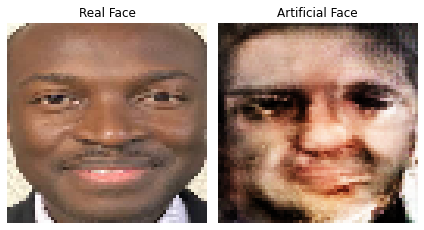

In [110]:
comparison(0)

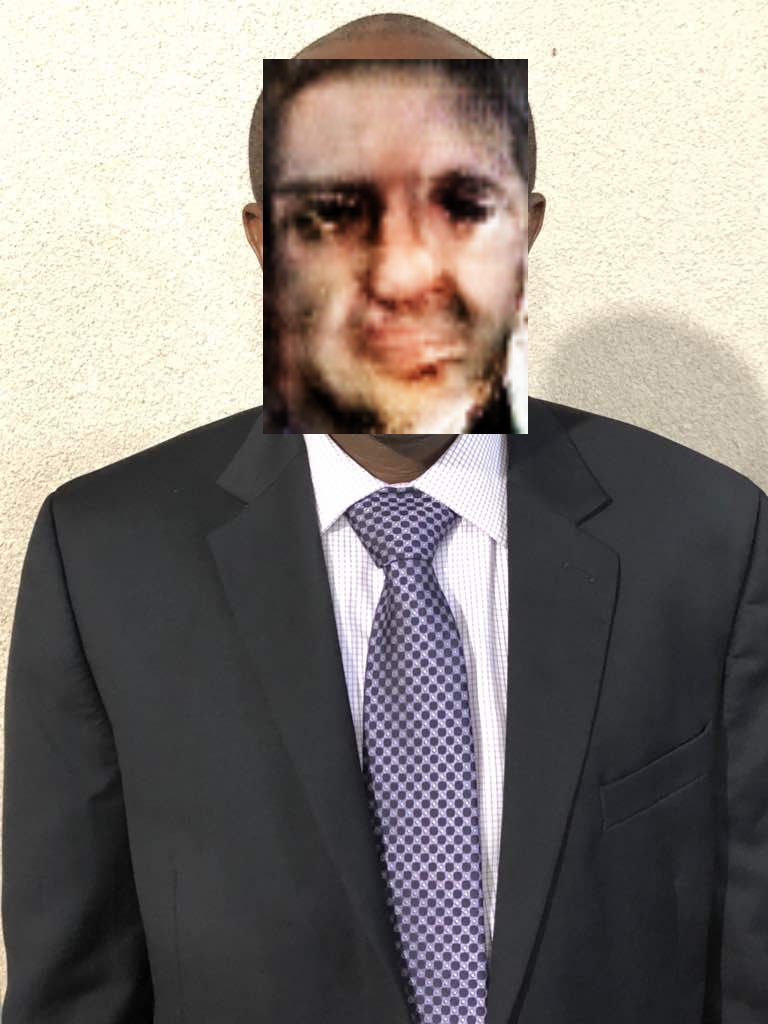

In [112]:
generate_image(0)

#### Test 2

Test 1: Actual Value 0 and Predicted Value 0


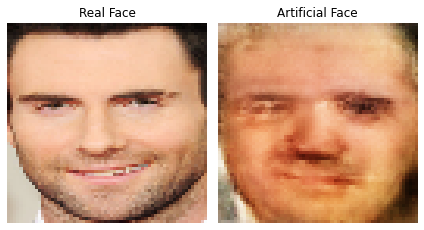

In [111]:
comparison(1)

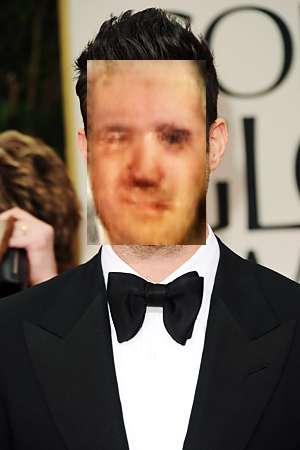

In [113]:
generate_image(1)

#### Test 3

Test 1: Actual Value 1 and Predicted Value 1


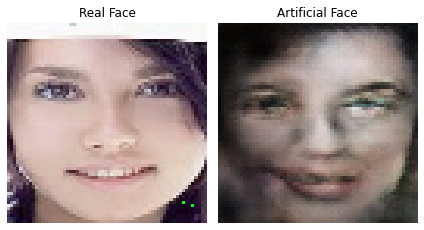

In [114]:
comparison(2)

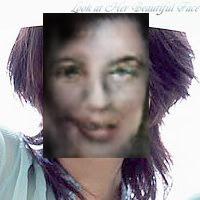

In [115]:
generate_image(2)

#### Test 4

Test 1: Actual Value 1 and Predicted Value 1


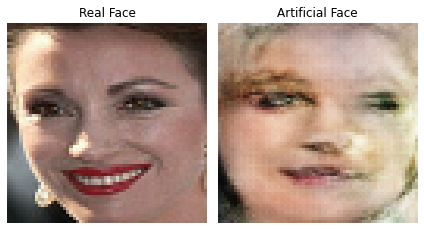

In [116]:
comparison(3)

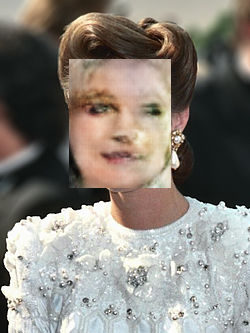

In [117]:
generate_image(3)

## Final Thoughts

The problem I set out to solve was the privacy concern a user might have when wanting to upload an image of himself or herself to the Internet, but the image includes other individuals. My solution was to use artificial human faces to replace real human faces in a user's picture before uploading it to the Internet. Even though I am far from a final product, I think I accomplished the primary aim of the solution and established a solid foundation that could be built upon. Here are a few highlights:

- Created a web scraper that successfully generated approximately 35k images for my dataset.
- Executed facial detection on each image in my dataset and progressed with images that had a 95% confidence level.
- Created a CNN gender classifier that detects male or female with 93% accuracy.
- Created two GANs: one for male artificial faces and one for female artificial faces.
  - I think the female GAN produced better results than the male GAN.
  - Though the results could be better, I think many facial features such as nose, chin, eyes, mouth / lips, hair and eyebrows can be identified.
  
With the following improvements, I think better results could be achieved.

- More images would be beneficial especially for training of the GANs.
- Thorough review and removal of duplicate images in original dataset.
- Thorough review and removal of images that might be incorrectly labeled.
- Implement different CNN architectures for gender classification.
- Implement different GAN architectures.
- Extensive parameter tuning for CNN and GANs.